## Info

with this notebook we test and visualize the functions that we use to normalize esr spectra to the background fluorescence.

As an input we need a dataset, that contains an esr spectrum as taken with the `ESR_simple` script class. For instance `190118-12_16_14_esr_simple_many_avg_NE_on`

In [ ]:
import sys
sys.path.append('/Users/rettentulla/PycharmProjects/b26_toolkit')
sys.path.append('/Users/rettentulla/PycharmProjects/pylabcontrol')

In [1]:
%matplotlib inline




from scipy import stats

import numpy as np

import numpy as np
import pandas as pd
import os



# print(sys.path)
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as sopt
# import pims
import scipy.spatial
import scipy.ndimage
from collections import Counter
import glob
import pylabcontrol

from pylabcontrol.core import Script

import h5py

import json, yaml

pix_to_um = 0.651 # conversion factor pixel to um

from pylabcontrol.data_processing import signal_processing as sp

def runningMeanFast(x, N=10):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]


import matplotlib 

FONT_SIZE = 20
matplotlib.rc('xtick', labelsize=FONT_SIZE) 
matplotlib.rc('ytick', labelsize=FONT_SIZE) 
matplotlib.rc('axes', titlesize=FONT_SIZE) 
matplotlib.rc('axes', labelsize=FONT_SIZE) 
matplotlib.rc('lines', linewidth=2) 

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
from b26_toolkit.data_processing.esr_signal_processing import get_counts_threshold
from b26_toolkit.data_processing.esr_signal_processing import get_background_idx
from b26_toolkit.data_processing.esr_signal_processing import split_counts_background

## reducing noise by estimating the reference fuorescence counts over time

### define the functions
=> outsource this to b26_toolkit

In [2]:
def esr_index_2_time_trace(esr_data, index_data):
    """
    
    get the esr into the right time order given by index_data
    
    inverse of time_trace_2_esr_index
    
    """
    
    time_trace = np.array([esr[idx] for esr, idx in zip(esr_data, index_data)])
    return time_trace


def time_trace_2_esr_index(time_trace, index_data):
    """
    
    inverse of esr_index_2_time_trace
    
    """
    
    
        
    esr_data = np.array([tt[idx] for tt, idx in zip(time_trace, index_data.argsort())])
    return esr_data


def running_mean(x, N, preserve_length=True):
    print(x)
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    
    avrg = (cumsum[N:] - cumsum[:-N]) / float(N)
    
    
    
    if preserve_length:
        # extrapolate with a polynomial fit to the values that are missing
        
        n = len(x)- len(avrg)
        y = avrg[0:n] 
        x = np.arange(n)
        
        print(x)
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)

        x = np.arange(-n,0)
        avrg = np.hstack([p(x), avrg])


    
    
    return avrg


### load the data

In [3]:
folder_path = '../'

filename =  os.path.join(folder_path,'190118-12_16_14_esr_simple_many_avg_NE_on')


# load data
data = Script.load_data(filename)
# load timestep
dt = Script.load_settings(filename)['integration_time']

### plot timetrace and smoothed timetraces

In [5]:
time_trace = esr_index_2_time_trace(data['esr_data'], data['index_data'])
esr_data = time_trace_2_esr_index(time_trace, data['index_data'])
# len(time_trace), len(smooth_tt)

[414.  402.  423.8 ... 435.9 447.5 454.2]
[0 1 2 3 4 5]
[0.0000e+00 1.0000e-02 2.0000e-02 ... 4.5297e+02 4.5298e+02 4.5299e+02]
[0 1 2 3 4 5]
(45300,) (45300,) (45300,)


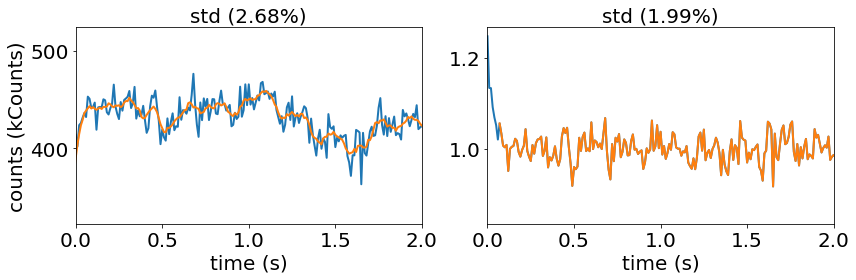

In [6]:
# using the indeces, we retrieve the right time ordering for the esr data and save it as the timetrace data
n_avrg = 7

plot_together = False
skip_n_avrg = True
set_xlim = True

time_trace = esr_index_2_time_trace(data['esr_data'], data['index_data']).ravel()
time = dt*np.arange(np.product(time_trace.shape))
if plot_together:
    fig, ax = plt.subplots(1,1, figsize = (6,4))
    ax = [ax]
else:
    fig, ax = plt.subplots(1,2, figsize = (12,4))

time_trace = time_trace.ravel()
if plot_together:
    time_trace = time_trace/np.mean(time_trace)

smooth_tt = running_mean(time_trace, n_avrg)

smooth_time = running_mean(time, n_avrg)
    
## plot the original data and the smoothed data
ax[0].plot(time,  time_trace)
ax[0].plot(smooth_time,  smooth_tt, label ='smooth')
if set_xlim:
    ax[0].set_xlim([0,2])
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('counts (kCounts)')
ax[0].set_title('std ({:0.2f}%)'.format(100*np.std(time_trace/np.mean(time_trace))))
if skip_n_avrg:
    ax[0].set_title('std ({:0.2f}%)'.format(100*np.std(time_trace[n_avrg:]/np.mean(time_trace[n_avrg:]))))
else:
    ax[0].set_title('std ({:0.2f}%)'.format(100*np.std(time_trace/np.mean(time_trace))))

print(time_trace.shape, smooth_tt.shape, time.shape)
if plot_together:
    idx = 0
else:
    idx = 1

## plot the normalized data
ax[idx].plot(time,  time_trace/smooth_tt)
ax[idx].plot(time[n_avrg:],  time_trace[n_avrg:]/smooth_tt[n_avrg:])
if set_xlim:
    ax[idx].set_xlim([0,2])
ax[idx].set_xlabel('time (s)')
if skip_n_avrg:
    ax[idx].set_title('std ({:0.2f}%)'.format(100*np.std(time_trace[n_avrg:]/smooth_tt[n_avrg:])))
else:
    ax[idx].set_title('std ({:0.2f}%)'.format(100*np.std(time_trace/smooth_tt)))
# ax[0].set_ylabel('counts (kCounts)')

# plt.legendlegend()
plt.tight_layout()

### smart averaging of the fluorescence over time

The main idea is the following:

1. first we identify the frequencies that correspond to the background, i.e. that are off-resonant.
    1. For this to work we require a rather broad spectrum, where at least half the frequency points do not correspond to a dip. 
    1. Identification is done by histogramming the full spectrum and identifying the mode of the histogram, ie. the most frequency count. We assume that those correspond to the background.
    1. Then we idenfify the frequencies with counts that are above the mode minus some threshold
    
1. Once we have the frequencies corresponding to the background, we consider only points in the fluorescence timetrace that correspond to the background frequencies.
    1. This leaves us with an unevenly sampled timetrace of fluorescence measured  of the background 
    1. To get the estimated background fluorescence we average only over data taken at the background freqs.
    
1. After we obtained the background fluorescence counts, we normalize the measuements by the background and reconstruct the esr data from the normalized measurements.


#### get the count threshold

In [8]:
esr_full = data['esr_data']
idx_data = data['index_data']

# esr_full = data['esr_data'][0:80]
# idx_data = data['index_data'][0:80]

frequencies = data['frequency']

idx_data.shape

(300, 151)

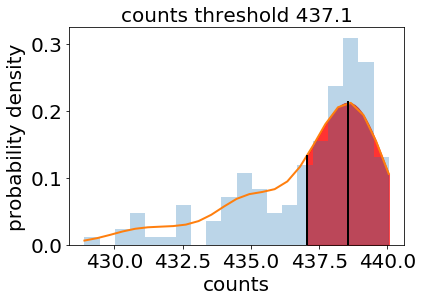

In [10]:
esr_mean = np.mean(esr_full, axis=0)

counts_threshold = get_counts_threshold(esr_mean, show_plot=True)

#### get the background frequencies

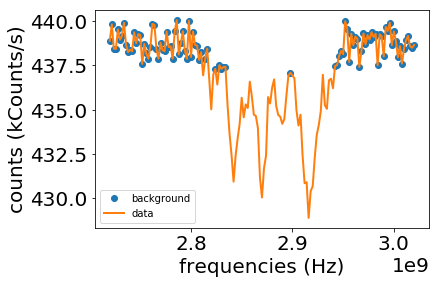

In [12]:
background_idx = get_background_idx(esr_mean, counts_threshold, frequencies=frequencies, show_plot=True)


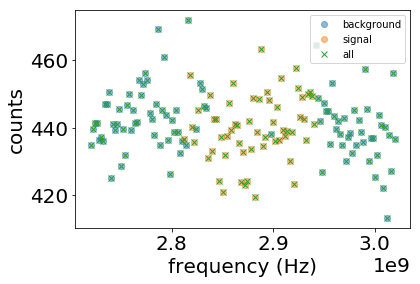

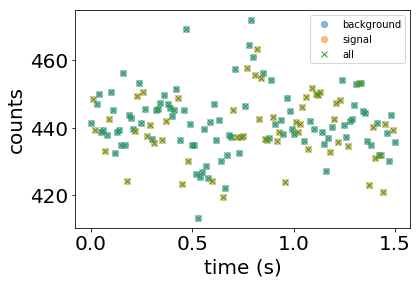

In [13]:

meas_id = 10

# plt.plot(frequencies, np.mean(esr_full, axis=0))
# plt.plot(frequencies, esr_full[meas_id])
return_dict1 = split_counts_background(idx_data[meas_id], esr_full[meas_id], frequencies, background_idx,dt=dt,
                                      show_plot=True, verbose=True,  freq_ordered=True)
plt.figure()
return_dict2 = split_counts_background(idx_data[meas_id], esr_full[meas_id], frequencies, background_idx,dt=dt,
                                      show_plot=True, verbose=True,  freq_ordered=False)


# plt.xlim([2.8e9, 2.9e9])

#### consistency check 1: signal should be the same just in different order

In [14]:
for key in return_dict1.keys():
    tmp = np.sort(return_dict1[key])-np.sort(return_dict2[key])
    if np.sum(np.sort(return_dict1[key])-np.sort(return_dict2[key])) != 0:
        print(key, np.sort(return_dict1[key]))
        print(key, tmp)

#### consistency check
- first plot, expect to see all the signal frequencies in the middle where the esr dip is
- second plot, expect to see two horizontral lines

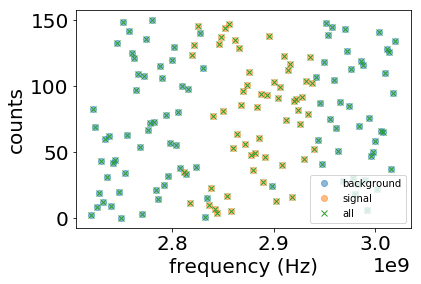

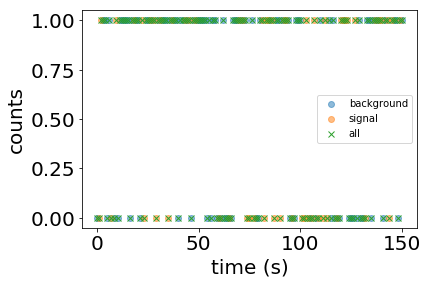

In [15]:
meas_id = 10

return_dict = split_counts_background(idx_data[meas_id], idx_data[meas_id], frequencies, background_idx,dt=dt,
                                      show_plot=True, verbose=True,  freq_ordered=True)

plt.figure()
tmp = idx_data[meas_id]

tmp = np.array([i in background_idx for i in idx_data[meas_id]])*1
return_dict = split_counts_background(idx_data[meas_id], tmp, frequencies,
                                      background_idx,dt=1,
                                      show_plot=True, verbose=True,  freq_ordered=False)




(434.37904093567255, 438.63588652482275)

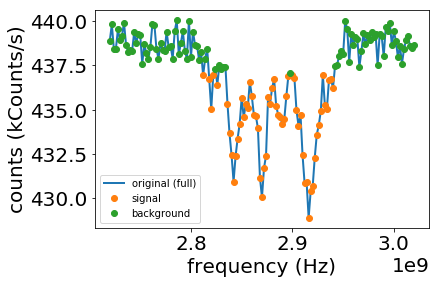

In [16]:
counts_background, counts_signal =[], []

for meas_id in range(len(esr_full)):
    return_dict = split_counts_background(
        idx_data[meas_id], esr_full[meas_id], frequencies, background_idx,dt=dt,
        show_plot=False, verbose=False,freq_ordered=True
    )

    counts_background.append(return_dict['counts_background'])
    counts_signal.append(return_dict['counts_signal'])
#     # time ordered signals
#     idx_b, s = return_dict['idx_background'], return_dict['counts_background']
#     # append freq sorted
#     counts_background.append(s[idx_b.argsort()])  
    
#     # time ordered signals
#     idx, s = return_dict['idx_signal'], return_dict['counts_signal']
#     # append freq sorted
#     counts_signal.append(s[idx.argsort()])

    
counts_background = np.array(counts_background)
counts_signal = np.array(counts_signal)

freq_background = return_dict['freqs_background']
freq_signal = return_dict['freqs_signal']

plt.plot(frequencies, np.mean(esr_full, axis=0), label='original (full)')

plt.plot(freq_signal, np.mean(counts_signal, axis=0), 'o', label='signal')

plt.plot(freq_background, np.mean(counts_background, axis=0), 'o', label='background')

plt.xlabel('frequency (Hz)')
plt.ylabel('counts (kCounts/s)')
plt.legend()

np.mean(counts_signal),np.mean(counts_background)

#### compare timetrace of signal and background

(434.37904093567255, 438.63588652482275)

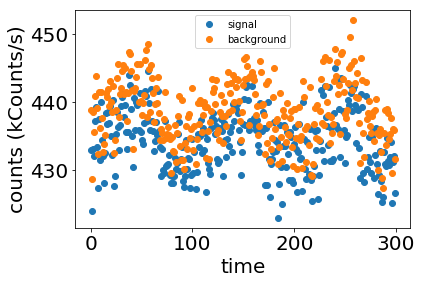

In [17]:
counts_background, counts_signal =[], []

for meas_id in range(len(esr_full)):
    return_dict = split_counts_background(
        idx_data[meas_id], esr_full[meas_id], frequencies, background_idx,dt=dt,
        show_plot=False, verbose=False,freq_ordered=True
    )

    counts_background.append(return_dict['counts_background'])
    counts_signal.append(return_dict['counts_signal'])


    
counts_background = np.array(counts_background)
counts_signal = np.array(counts_signal)

freq_background = return_dict['freqs_background']
freq_signal = return_dict['freqs_signal']

# plt.plot(np.mean(esr_full, axis=0), label='original (full)')

plt.plot(np.mean(counts_signal, axis=1), 'o', label='signal')

plt.plot(np.mean(counts_background, axis=1), 'o', label='background')

plt.xlabel('time')
plt.ylabel('counts (kCounts/s)')
plt.legend()

np.mean(counts_signal),np.mean(counts_background)

#### signal and background are very correlated
so we don't win too much by normalizeing with the background over just normalizing with the mean

Text(0.5,0,'background')

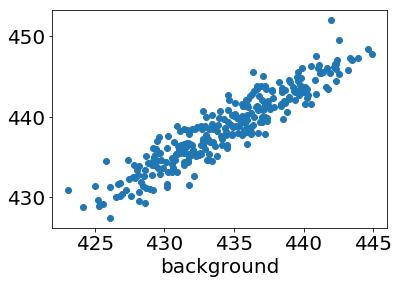

In [18]:
plt.plot(np.mean(counts_signal, axis=1), np.mean(counts_background, axis=1), 'o')
plt.xlabel('signal')
plt.xlabel('background')

#### compare the original time trace and the corrected

(434.37904093567255, 438.63588652482275)

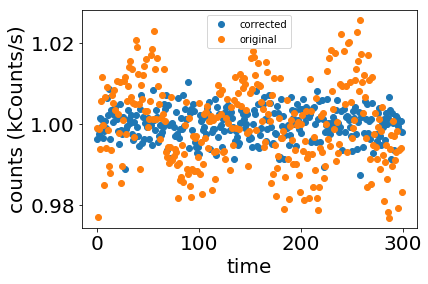

In [19]:
counts_background, counts_signal =[], []

for meas_id in range(len(esr_full)):
    return_dict = split_counts_background(
        idx_data[meas_id], esr_full[meas_id], frequencies, background_idx,dt=dt,
        show_plot=False, verbose=False,freq_ordered=True
    )

    counts_background.append(return_dict['counts_background'])
    counts_signal.append(return_dict['counts_signal'])


    
counts_background = np.array(counts_background)
counts_signal = np.array(counts_signal)

freq_background = return_dict['freqs_background']
freq_signal = return_dict['freqs_signal']

# plt.plot(np.mean(esr_full, axis=0), label='original (full)')
corrected = np.mean(counts_signal, axis=1)/np.mean(counts_background, axis=1)
original = np.mean(esr_full, axis=1)/np.mean(esr_full)

plt.plot(corrected/np.mean(corrected), 'o', label='corrected')
plt.plot(original/np.mean(original), 'o', label='original')
# plt.plot(np.mean(counts_signal, axis=1)/np.mean(counts_background, axis=1), 'o')

plt.xlabel('time')
plt.ylabel('counts (kCounts/s)')
plt.legend()

np.mean(counts_signal),np.mean(counts_background)

In [20]:
# np.array([np.mean(counts_background, axis=1)]).shape, np.ones([1, esr_full.shape[1]]).shape, 


In [21]:
# counts_background.shape, counts_signal.shape, esr_full.shape

In [22]:
# back_norm[:,0]

#### corrected spectrum - not really an improvement for this dataset

(434.37904093567255, 438.63588652482275)

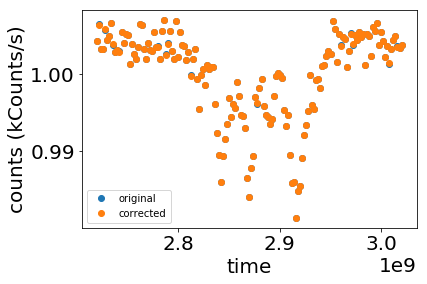

In [23]:
counts_background, counts_signal =[], []

for meas_id in range(len(esr_full)):
    return_dict = split_counts_background(
        idx_data[meas_id], esr_full[meas_id], frequencies, background_idx,dt=dt,
        show_plot=False, verbose=False,freq_ordered=True
    )

    counts_background.append(return_dict['counts_background'])
    counts_signal.append(return_dict['counts_signal'])


    
counts_background = np.array(counts_background)
counts_signal = np.array(counts_signal)

freq_background = return_dict['freqs_background']
freq_signal = return_dict['freqs_signal']

# plt.plot(np.mean(esr_full, axis=0), label='original (full)')

back_norm = (np.ones([esr_full.shape[1],1])*np.array([np.mean(counts_background, axis=1)])).T

corrected = np.mean(esr_full/back_norm, axis=0)
original = np.mean(esr_full, axis=0)

# plt.plot(corrected/np.mean(corrected), 'o', label='corrected')
plt.plot(frequencies, original/np.mean(original), 'o', label='original')
plt.plot(frequencies, corrected/np.mean(corrected), 'o', label='corrected')
# plt.plot(np.mean(counts_signal, axis=1)/np.mean(counts_background, axis=1), 'o')

plt.xlabel('time')
plt.ylabel('counts (kCounts/s)')
plt.legend()

np.mean(counts_signal),np.mean(counts_background)